# Topological Data Analysis (TDA)

TDA for detecting changes in time series.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd


import umap

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """
    Taken from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

## Get raw data

In [2]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

---

## Sliding window embeddings

Extract sliding window delayed embeddings from time series for each week.

Can also consider using HMM to model sequence and encode sequence using Fisher vector approach.

In [5]:
def sliding_win_embeddings(x, dim, Tau, dT):
    """
    Taken from https://github.com/lightalchemist/TUMTopoTimeSeries2016/blob/master/1-SlidingWindowBasics.ipynb
    """
    import scipy.interpolate as interp
    
    N = len(x)
    NWindows = int(np.floor((N - dim * Tau) / dT))  #The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    
    X = np.zeros((NWindows,
                  dim))  #Create a 2D array which will store all windows
    idx = np.arange(N)
    
    order = []
    for i in range(NWindows):
        #Figure out the indices of the samples in this window
        idxx = dT * i + Tau * np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1])) + 2
        if end >= len(x):
            X = X[0:i, :]
            break
        #Do spline interpolation to fill in this window, and place
        #it in the resulting array
        X[i, :] = interp.spline(idx[start:end + 1], x[start:end + 1], idxx)
        
        # Set order to be time of day
        
        order.append((start + end) / 2)
    
    order = np.asarray(order)
        
    return X, order

In [7]:
dim = 20
# dim = 10
tau = 1
# dT = 0.5
dT = 1

# TODO: Configure period to be a day
# TODO: What are dim, tau, and dT?

# 2016 data
grouper = df1.groupby([df1.index.week])
keys = list(grouper.groups.keys())

x1 = grouper.get_group(keys[0]).totalkw
x2 = grouper.get_group(keys[1]).totalkw

X1, order_x1 = sliding_win_embeddings(x1, dim, tau, dT)
X2, order_x2 = sliding_win_embeddings(x2, dim, tau, dT)

# 2018 data
grouper = df2.groupby([df2.index.week])
keys = list(grouper.groups.keys())

# Skip first group which only consists of 1 day
y1 = grouper.get_group(keys[1]).totalkw
y2 = grouper.get_group(keys[4]).totalkw

Y1, order_y1 = sliding_win_embeddings(y1, dim, tau, dT)
Y2, order_y2 = sliding_win_embeddings(y2, dim, tau, dT)

/home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


In [8]:
X1.shape, X2.shape, Y1.shape, Y2.shape

((10044, 20), (10025, 20), (10028, 20), (10033, 20))

In [9]:
%store X1
%store X2
%store Y1
%store Y2

Stored 'X1' (ndarray)
Stored 'X2' (ndarray)
Stored 'Y1' (ndarray)
Stored 'Y2' (ndarray)


In [ ]:
%store -r X1
%store -r X2
%store -r Y1
%store -r Y2

## Plot UMAP embeddings

In [ ]:
reducer = umap.

## Plot sliding window embeddings

Plot 3D PCA embeddings of sliding window embeddings.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

%matplotlib notebook
%matplotlib notebook

pca = PCA(n_components=3)

XX1 = pca.fit_transform(X1)
XX2 = pca.fit_transform(X2)

YY1 = pca.fit_transform(Y1)
YY2 = pca.fit_transform(Y2)

<IPython.core.display.Javascript object>


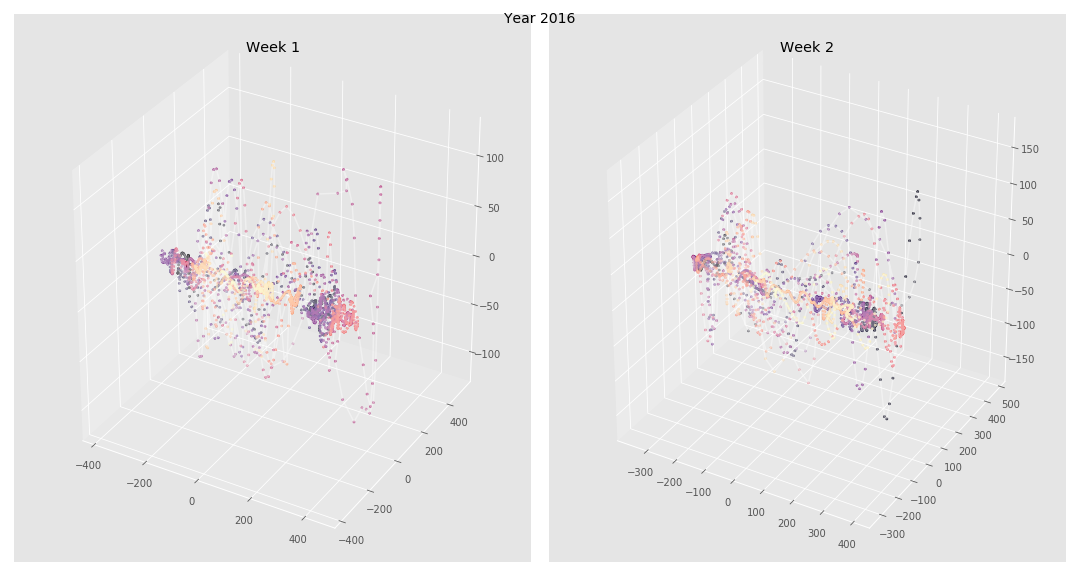

In [32]:
plt.figure(figsize=(15, 8))

for i, (Y, order, label) in enumerate(zip([XX1, XX2], 
                                   [order_x1, order_x2],
                                   ["Week 1", "Week 2"]
                                  ), 1):
    
    ax = plt.subplot(1, 2, i, projection="3d")    
    
    ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'white', alpha=0.4)    
    
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], 
                 marker='.', #alpha=1,
                 c=order, 
                 cmap='magma',
                 label=label
                )
        
    ax.set_aspect('equal', 'datalim')
    ax.set_title(label)


plt.suptitle("Year 2016", fontsize=14)

plt.tight_layout()

<IPython.core.display.Javascript object>


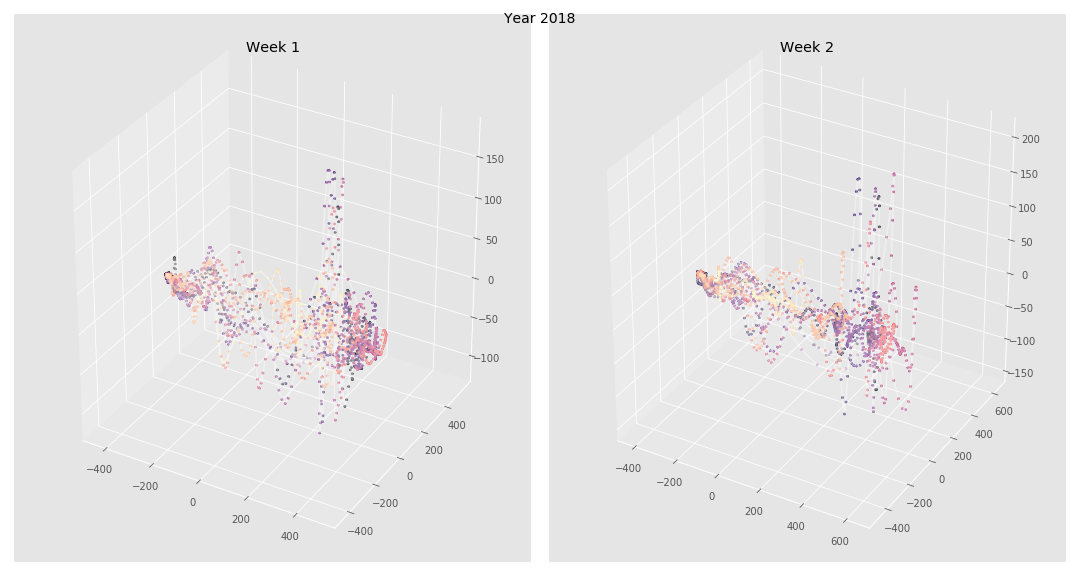

In [33]:
plt.figure(figsize=(15, 8))

step = 1
for i, (Y, order, label) in enumerate(zip([YY1, YY2], 
                                   [order_y1, order_y2],
                                   ["Week 1", "Week 2"]
                                  ), 1):
    
    ax = plt.subplot(1, 2, i, projection="3d")    
    
    ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'white', alpha=0.4)    
    
    ax.scatter3D(Y[::step, 0], Y[::step, 1], Y[::step, 2], 
                 marker='.', # alpha=0.5,
                 c=order[::step], 
                 cmap='magma',
                 label=label
                )
        
    ax.set_aspect('equal', 'datalim')
    ax.set_title(label)


plt.suptitle("Year 2018", fontsize=14)

plt.tight_layout()

In [36]:
import ipyvolume as ipv

In [37]:
ipv.quickscatter(XX1[:, 0], XX1[:, 1], XX1[:, 2],
                 size=0.5, marker="sphere")

In [38]:
ipv.quickscatter(XX2[:, 0], XX2[:, 1], XX2[:, 2],
                 size=0.5, marker="sphere")

In [39]:
ipv.quickscatter(YY1[:, 0], YY1[:, 1], YY1[:, 2],
                 size=0.5, marker="sphere")

In [40]:
ipv.quickscatter(YY2[:, 0], YY2[:, 1], YY2[:, 2],
                 size=0.5, marker="sphere")

## TDA distance between descriptors

Compute persistent disgrams for sliding window embeddings.

Can compute on raw data or on PCA embeddings.

Consider using Witness complex or Alpha complex (on PCA embeddings).

Reduce number of points (maybe 2 to 3 days or resample time-series).

Consider using R version for TDA.

Tune $\tau, d, \delta_t$ for generating sliding window embeddings.

**TODO: Compare R-TDA bottleneck distance to Gudhi's bottleneck distance.**

In [41]:
def compute_persistence(X, max_edge_length=0.5, max_dim=1, complex_type="rips"):
    allowed_types = ("rips", "alpha", "witness")
    assert complex_type in allowed_types, "complex_type must be one of {}".format(("rips", "alpha", "witness"))
    
    if complex_type == "rips":
        sim_complex = gd.RipsComplex(points=X.tolist(), max_edge_length=max_edge_length)
        simplex_tree = sim_complex.create_simplex_tree(max_dimension=max_dim)
    elif complex_type == "alpha":
        sim_complex = gd.AlphaComplex(points=X.tolist())
        simplex_tree = sim_complex.create_simplex_tree()
        
    diag = simplex_tree.persistence()
    return sim_complex, simplex_tree, diag

In [42]:
max_dim = 2
max_edge_length = 0.5
complex_type = "alpha"

sim_complexX1, simtreeX1, diagX1 = compute_persistence(XX1, max_edge_length, max_dim, complex_type)
sim_complexX2, simtreeX2, diagX2 = compute_persistence(XX2, max_edge_length, max_dim, complex_type)
sim_complexY1, simtreeY1, diagY1 = compute_persistence(YY1, max_edge_length, max_dim, complex_type)
sim_complexY2, simtreeY2, diagY2 = compute_persistence(YY2, max_edge_length, max_dim, complex_type)

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

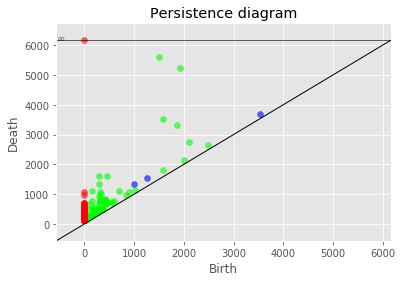

In [44]:
gd.plot_persistence_diagram(diagX1, max_plots=200)

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

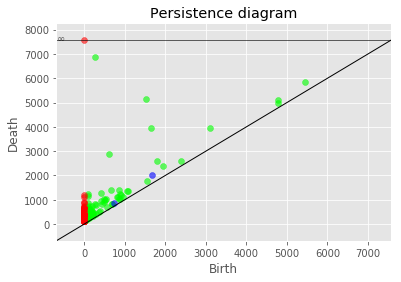

In [45]:
gd.plot_persistence_diagram(diagX2, max_plots=200)

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

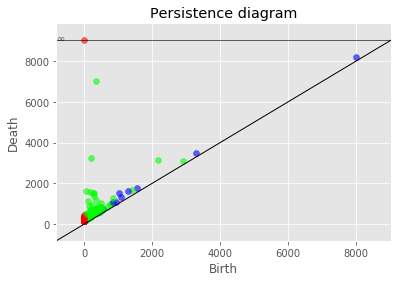

In [46]:
gd.plot_persistence_diagram(diagY1, max_plots=200)

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

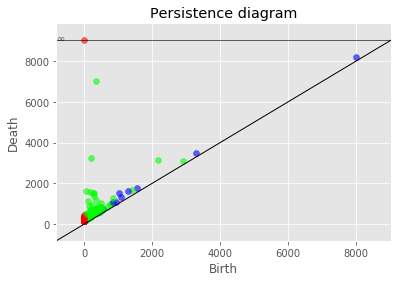

In [47]:
gd.plot_persistence_diagram(diagY1, max_plots=200)

## Visualize distances between weeks

In [ ]:
dim = 1
eta = 0.01
gd.bottleneck_distance(simtreeY2.persistence_intervals_in_dimension(dim),
                       simtreeX1.persistence_intervals_in_dimension(dim),
                       eta)

In [ ]:
dim = 0
eta = 0.01

X = (simtreeX1, simtreeX2, simtreeY1, simtreeY2)

N = len(X)
dist = np.zeros((N, N))

for i in range(N):
    simtree_i = X[i]    
    for j in range(i + 1, N):
        simtree_j = X[j]
        d = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                   simtree_j.persistence_intervals_in_dimension(dim),
                                   eta)
        dist[i, j] = d        

In [ ]:
plt.matshow(dist + dist.T, cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
dist + dist.T

In [ ]:
dim = 1
eta = 0.01

X = (simtreeX1, simtreeX2, simtreeY1, simtreeY2)

N = len(X)
dist = np.zeros((N, N))

for i in range(N):
    simtree_i = X[i]    
    for j in range(i + 1, N):
        simtree_j = X[j]
        d = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                   simtree_j.persistence_intervals_in_dimension(dim),
                                   eta)
        dist[i, j] = d        

In [ ]:
plt.matshow(dist + dist.T, cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
dist + dist.T

In [ ]:
dim = 2
eta = 0.01

X = (simtreeX1, simtreeX2, simtreeY1, simtreeY2)

N = len(X)
dist = np.zeros((N, N))

for i in range(N):
    simtree_i = X[i]    
    for j in range(i + 1, N):
        simtree_j = X[j]
        d = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                   simtree_j.persistence_intervals_in_dimension(dim),
                                   eta)
        dist[i, j] = d        

In [ ]:
plt.matshow(dist + dist.T, cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
dist + dist.T

## Perform statistical tests

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib notebook

In [ ]:
import holoviews as hv

# hv.notebook_extension('bokeh', 'matplotlib')

hv.extension('matplotlib')
# hv.extension('bokeh')

---

# Miscellaneous code

Experiment with Plotly 3D interactive visualizations. This is faster than the Bokeh and Matplotlib-based visualizations at the cost of using much more memory as it uses WebGL to render the graphs locally whereas
Bokeh and Matplotlib are rendered on the server.

In [ ]:
import plotly as py
import plotly.graph_objs as go

import ipywidgets as widgets
from scipy import special

py.offline.init_notebook_mode(connected=True)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
import plotly

In [ ]:
def plot_3d_embeddings(*data, rgba=(217, 217, 217, 0.1), size=1, opacity=0.3, ncols=2):
    n_datasets = len(data)
    nrows = int(n_datasets / ncols + 0.5)
    
    traces = []
    rows = []
    cols = []
    for i, X in enumerate(data):
        r = i // ncols + 1
        c = i % ncols + 1
        
        rows.append(r)
        cols.append(c)
        trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                             mode='markers',
                             marker=dict(size=size, 
                                         line=dict(color='rgba({}, {}, {}, {})'.format(*rgba),
                                                   width=0.5),
                                         color="blue",
                                         opacity=opacity))
        traces.append(trace)
    
#     trace1 = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
#                             mode='markers',
#                             marker=dict(
#                                 size=size,
#                                 line=dict(
#                                     color='rgba(217, 217, 217, 0.14)',
#                                     width=0.5
#                                 ),
#                                 opacity=opacity
#                             ))

#     layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
#     fig = go.Figure(data=[trace1], layout=layout)
#     py.offline.iplot(fig, filename='simple-3d-scatter')
    
    specs = []
    for r in range(nrows):
        rspecs = []
        for c in range(ncols):
            rspecs.append({'is_3d': True})
        specs.append(rspecs)
        
    fig = tools.make_subplots(rows=nrows, 
                              cols=ncols, 
                              specs=specs,
                              horizontal_spacing=0.05)
    fig.add_traces(traces, rows, cols)
    margin = {
    "r": 10,
    "t": 25,
    "b": 40,
    "l": 60
    }
    fig.layout = go.Layout(margin=margin, height=600, width=600)
    
#     fig = go.Figure(rows=nrows, cols=ncols, data=traces, layout=layout)
    py.offline.iplot(fig, filename='simple-3d-scatter')

In [ ]:
plot_3d_embeddings(XX1, XX2, YY1, YY2)

---

In [ ]:
grouper = df2.loc[:, features].groupby([df2.index.week])
keys = list(grouper.groups.keys())
g = grouper.get_group(keys[1])

In [ ]:
len(keys)

In [ ]:
td = (g.index.max() - g.index.min())

In [ ]:
td.days

In [ ]:
grouper.get_group(keys[1])

In [ ]:
len(keys)